Author: KuoChen Huang

## Decision Trees as Interpretable Models

###  (a) Download the Accute Inflamations data from https://archive.ics.uci.edu/ ml/datasets/Acute+Inflammations.


Attributes: Temperature of patient/ Occurrence of nausea/ Lumbar pain/ Urine pushing (continuous need for urination)/  
    Micturition pains/ Burning of urethra, itch, swelling of urethra outlet/ decision: Inflammation of urinary bladder/ decision: Nephritis of renal pelvis origin 

In [1]:
import pandas as pd
import numpy as np 
from skmultilearn.problem_transform import LabelPowerset
AI_columns_name = ['Temperature', 'Occurrence of nausea', 'Lumbar pain', 'Urine pushing',  
                   'Micturition pains', 'Burning of urethra, itch, swelling of urethra outlet',  
                   'decision: Inflammation of urinary bladder', 'decision: Nephritis of renal pelvis origin']

In [2]:
def readFile_1(filename):
    data_dict = dict()

    for col in AI_columns_name:
        data_dict[col] = list()
    
    for line in open(filename, encoding = 'utf16'):
        line = line.rstrip()
        line = line.replace(',','.').split("\t")
        info_len = len(line)
        
        for i in range(info_len):
            data_dict[AI_columns_name[i]].append(line[i])
    
    data = pd.DataFrame.from_dict(data_dict)
    return data

In [3]:
dataset = readFile_1('../data/diagnosis.data')
dataset = dataset.astype({'Temperature': float})

### (b) Build a decision tree on the whole data set and plot it.

I would build three tree in the following question.
1) take decision1 and decision2 into consideration and convert them into class 1/2/3/4  
2) only focused on decision1 class 0/1  
3) only focused on decision2 class 0/1

In [4]:
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
from sklearn.tree import _tree
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from sklearn import metrics
from skmultilearn.problem_transform import LabelPowerset
from sklearn.tree import export_text
from sklearn.model_selection import cross_val_score

In [5]:
# convert the YES/NO into 1/0
lb = LabelEncoder() 
for i in range(1, len(AI_columns_name)):
    dataset[AI_columns_name[i]] = lb.fit_transform(dataset[AI_columns_name[i]]) 

In [6]:
X = dataset[['Temperature', 'Occurrence of nausea', 'Lumbar pain', 'Urine pushing', 
            'Micturition pains', 'Burning of urethra, itch, swelling of urethra outlet']]
Y_Urinary = dataset['decision: Inflammation of urinary bladder']
Y_Nephritis = dataset['decision: Nephritis of renal pelvis origin']
#dataset.head()

In [7]:
dataset.loc[((dataset['decision: Inflammation of urinary bladder']==0) &  
            (dataset['decision: Nephritis of renal pelvis origin']==0)), 'decision: combined'] = int(1)

dataset.loc[((dataset['decision: Inflammation of urinary bladder']==0) &  
            (dataset['decision: Nephritis of renal pelvis origin']==1)), 'decision: combined'] = int(2)

dataset.loc[((dataset['decision: Inflammation of urinary bladder']==1) &  
            (dataset['decision: Nephritis of renal pelvis origin']==0)), 'decision: combined'] = int(3)

dataset.loc[((dataset['decision: Inflammation of urinary bladder']==1) &  
            (dataset['decision: Nephritis of renal pelvis origin']==1)), 'decision: combined'] = int(4)
#dataset.head()
Y = dataset[['decision: combined']]

Try(1) MultiLabel

In [8]:
clf1 = DecisionTreeClassifier()
model1 = clf1.fit(X, Y)
y_predict_1 = model1.predict(X)
print("Accuracy:", metrics.accuracy_score(Y, y_predict_1))

Accuracy: 1.0


|--- Lumbar pain <= 0.50
|   |--- Urine pushing <= 0.50
|   |   |--- class: 1.0
|   |--- Urine pushing >  0.50
|   |   |--- class: 3.0
|--- Lumbar pain >  0.50
|   |--- Temperature <= 37.95
|   |   |--- class: 1.0
|   |--- Temperature >  37.95
|   |   |--- Occurrence of nausea <= 0.50
|   |   |   |--- class: 2.0
|   |   |--- Occurrence of nausea >  0.50
|   |   |   |--- Urine pushing <= 0.50
|   |   |   |   |--- class: 2.0
|   |   |   |--- Urine pushing >  0.50
|   |   |   |   |--- class: 4.0



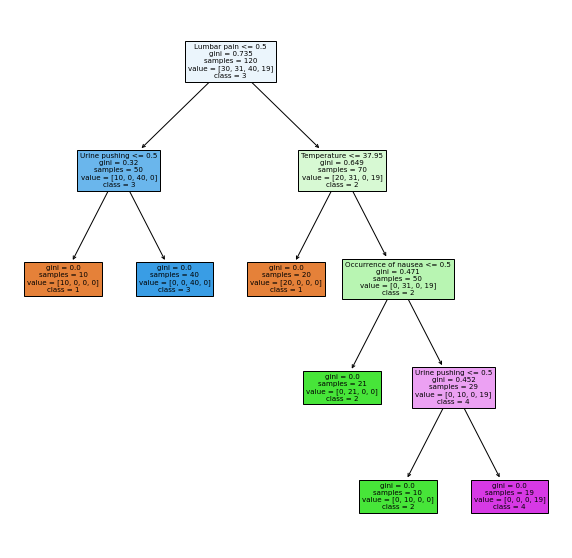

In [9]:
text_representation = export_text(model1, feature_names = list(X.columns))
print(text_representation)

fig = plt.figure(figsize=(10,10))
plot_tree = tree.plot_tree(clf1, 
                   feature_names = X.columns,  
                   class_names = ['1', '2', '3', '4'],
                   filled = True)

Try(2) Only focused on decision1: Inflammation of urinary bladder

In [10]:
clf2 = DecisionTreeClassifier(random_state=1234)
model2 = clf2.fit(X, Y_Urinary)

|--- Urine pushing <= 0.50
|   |--- class: 0
|--- Urine pushing >  0.50
|   |--- Micturition pains <= 0.50
|   |   |--- Lumbar pain <= 0.50
|   |   |   |--- class: 1
|   |   |--- Lumbar pain >  0.50
|   |   |   |--- class: 0
|   |--- Micturition pains >  0.50
|   |   |--- class: 1



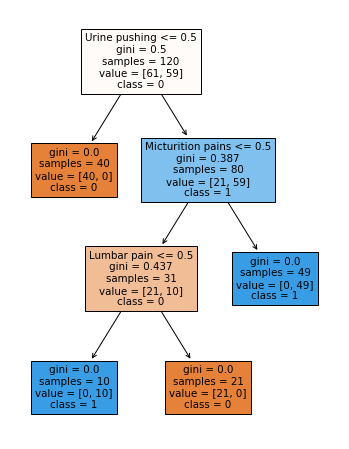

In [12]:
text_representation = export_text(model2, feature_names = list(X.columns))
print(text_representation)
fig = plt.figure(figsize=(6,8))
_ = tree.plot_tree(clf2, 
                   feature_names = X.columns,
                   class_names = ['0', '1'],
                   filled = True)

Try(3) Only focused on decision2: Nephritis of renal pelvis origin

In [12]:
clf3 = DecisionTreeClassifier(random_state=1234)
model3 = clf3.fit(X, Y_Nephritis)

|--- Temperature <= 37.95
|   |--- class: 0
|--- Temperature >  37.95
|   |--- Lumbar pain <= 0.50
|   |   |--- class: 0
|   |--- Lumbar pain >  0.50
|   |   |--- class: 1



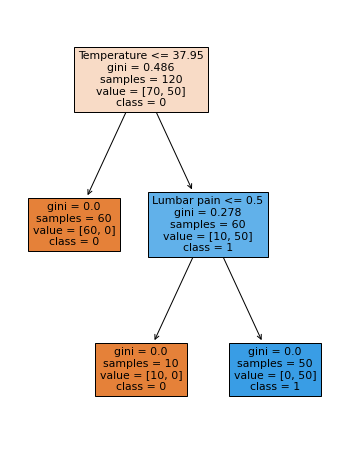

In [13]:
text_representation = export_text(model3, feature_names = list(X.columns))
print(text_representation)
fig = plt.figure(figsize=(6,8))
_ = tree.plot_tree(clf3, 
                   feature_names = X.columns,  
                   class_names = ['0', '1'],
                   filled = True)

### (c) Convert the decision rules into a set of IF-THEN rules.

In [14]:
def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    print ("def tree({}):".format(", ".join(feature_names)))
    
    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_names[node]
            threshold = tree_.threshold[node]
            print ("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print ("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print ("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

In [15]:
def tree_to_code_2(tree, feature_names):
    tree_ = tree.tree_
    print ("def tree({}):".format(", ".join(feature_names)))

    print(" ")
    left = tree.tree_.children_left
    right = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value

    def recurse(left, right, threshold, features, node, depth=0):
        indent = "  " * depth
        if (threshold[node] != -2):
            print (indent,"if ( " + features[node] + " <= " + str(threshold[node]) + " ) {")
            if left[node] != -1:
                recurse (left, right, threshold, features, left[node], depth+1)
                print (indent,"} else {")
                if right[node] != -1:
                    recurse (left, right, threshold, features, right[node], depth+1)
                print (indent,"}")
        else:
            print (indent,"return " + str(value[node]))

    recurse(left, right, threshold, features, 0)

In [16]:
# take decision1 and decision2 together
tree_to_code_2(model1, X.columns)

def tree(Temperature, Occurrence of nausea, Lumbar pain, Urine pushing, Micturition pains, Burning of urethra, itch, swelling of urethra outlet):
 
 if ( Lumbar pain <= 0.5 ) {
   if ( Temperature <= 38.95000076293945 ) {
     return [[ 0.  0. 40.  0.]]
   } else {
     return [[10.  0.  0.  0.]]
   }
 } else {
   if ( Temperature <= 37.95000076293945 ) {
     return [[20.  0.  0.  0.]]
   } else {
     if ( Micturition pains <= 0.5 ) {
       return [[ 0. 21.  0.  0.]]
     } else {
       if ( Urine pushing <= 0.5 ) {
         return [[ 0. 10.  0.  0.]]
       } else {
         return [[ 0.  0.  0. 19.]]
       }
     }
   }
 }


In [17]:
# decision1: Inflammation of urinary bladder
tree_to_code(model2, X.columns)

def tree(Temperature, Occurrence of nausea, Lumbar pain, Urine pushing, Micturition pains, Burning of urethra, itch, swelling of urethra outlet):
  if Temperature <= 0.5:
    return [[40.  0.]]
  else:  # if Temperature > 0.5
    if Lumbar pain <= 0.5:
      if Urine pushing <= 0.5:
        return [[ 0. 10.]]
      else:  # if Urine pushing > 0.5
        return [[21.  0.]]
    else:  # if Lumbar pain > 0.5
      return [[ 0. 49.]]


In [18]:
# decision2: Nephritis of renal pelvis origin 
tree_to_code(model3, X.columns)

def tree(Temperature, Occurrence of nausea, Lumbar pain, Urine pushing, Micturition pains, Burning of urethra, itch, swelling of urethra outlet):
  if Temperature <= 37.95000076293945:
    return [[60.  0.]]
  else:  # if Temperature > 37.95000076293945
    if Lumbar pain <= 0.5:
      return [[10.  0.]]
    else:  # if Lumbar pain > 0.5
      return [[ 0. 50.]]


###  (d) Use cost-complexity pruning to find a minimal decision tree and a set of decision rules with high interpretability.

In [19]:
path = clf1.cost_complexity_pruning_path(X,Y)

#The parameter ccp_alpha provides a threshold for effective alphas,  
#i.e. the process of pruning continues until the minimal effective alpha 
#of the pruned tree is not greater than ccp_alpha.

alphas = path['ccp_alphas']
impurities = path['impurities']
alphas

array([0.        , 0.09816667, 0.13333333, 0.182     , 0.22291667])

In [20]:
# 5-fold cross-validation
alpha_score = dict()
for j in alphas:
    alpha_score[j] = list()
    
for j in alphas: 
    for i in range(2,6):
        tree = DecisionTreeClassifier(ccp_alpha = j)
        scores = cross_val_score(estimator = tree, X = X, y = Y, cv = i)
        #print(scores.mean())
        alpha_score[j].append(scores.mean())
        
result = dict()
for k,v in alpha_score.items():
    result[k] = sum(v)/len(v)

Text(0, 0.5, 'scores')

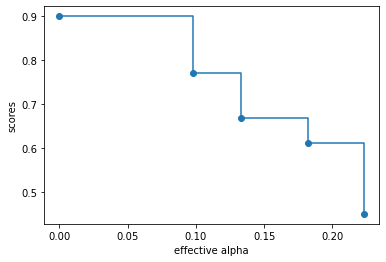

In [21]:
fig, ax = plt.subplots()
ax.plot(alphas, list(result.values()), marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("scores")

Text(0, 0.5, 'total impurity of leaves')

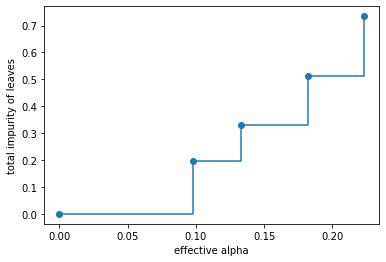

In [22]:
# just my practice
fig, ax = plt.subplots()
ax.plot(alphas, impurities, marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
#ax.set_title("Total Impurity vs effective alpha for training set")

Since maximum effective alpha value is meaningless, that it generates the trivial tree with only one node.  
Thus, I would choose alpha = 0.18199 to prune my tree!

In [23]:
tree = DecisionTreeClassifier(ccp_alpha = alphas[-2])
tree.fit(X,Y)
text_representation = export_text(tree, feature_names = list(X.columns))
print("========== alpha: " + str(alphas[-2]) + " ==========" )
print(" ")
print(text_representation)
print(" ")
print("Accuracy on whole data: ", tree.score(X,Y) )

========== alpha: 0.18199999999999997 ==========
 
|--- Lumbar pain <= 0.50
|   |--- class: 3.0
|--- Lumbar pain >  0.50
|   |--- class: 2.0

 
Accuracy on whole data:  0.5916666666666667


## The LASSO and Boosting for Regression

### (a) Download the Communities and Crime data3 from https://archive.ics.uci. edu/ml/datasets/Communities+and+Crime. Use the first 1495 rows of data as the training set and the rest as the test set.

In [24]:
def readFile_2(filename):
    C_columns_name = []
    for line in open(filename):
        if '@attribute' in line:
            col = line.split(' ')
            C_columns_name.append(col[1])
            
    data = pd.read_csv('../data/communities.data', header = None, names = C_columns_name)
    data = data.replace('?',np.nan)
    return C_columns_name, data

In [25]:
C_columns_name, data = readFile_2('../data/communities.names')

In [26]:
train, test = data[:1495], data[1495:]

In [27]:
len(data.columns)
# 122 predictive, 5 non-predictive, 1 goal

128

###  (b) The data set has missing values. Use a data imputation technique to deal with the missing values in the data set. The data description mentions some features are nonpredictive. Ignore those features.

In [28]:
from sklearn.impute import SimpleImputer

In [29]:
# drop the non-predictive value
data = data.drop(['state', 'county', 'community', 'communityname', 'fold'], axis=1)

In [30]:
# replacing NaN with mean
imputation = SimpleImputer(missing_values=np.nan, strategy = 'mean')
data = imputation.fit_transform(data)
data = pd.DataFrame(data, columns = C_columns_name[5:])

### (c) Plot a correlation matrix for the features in the data set.

<AxesSubplot:>

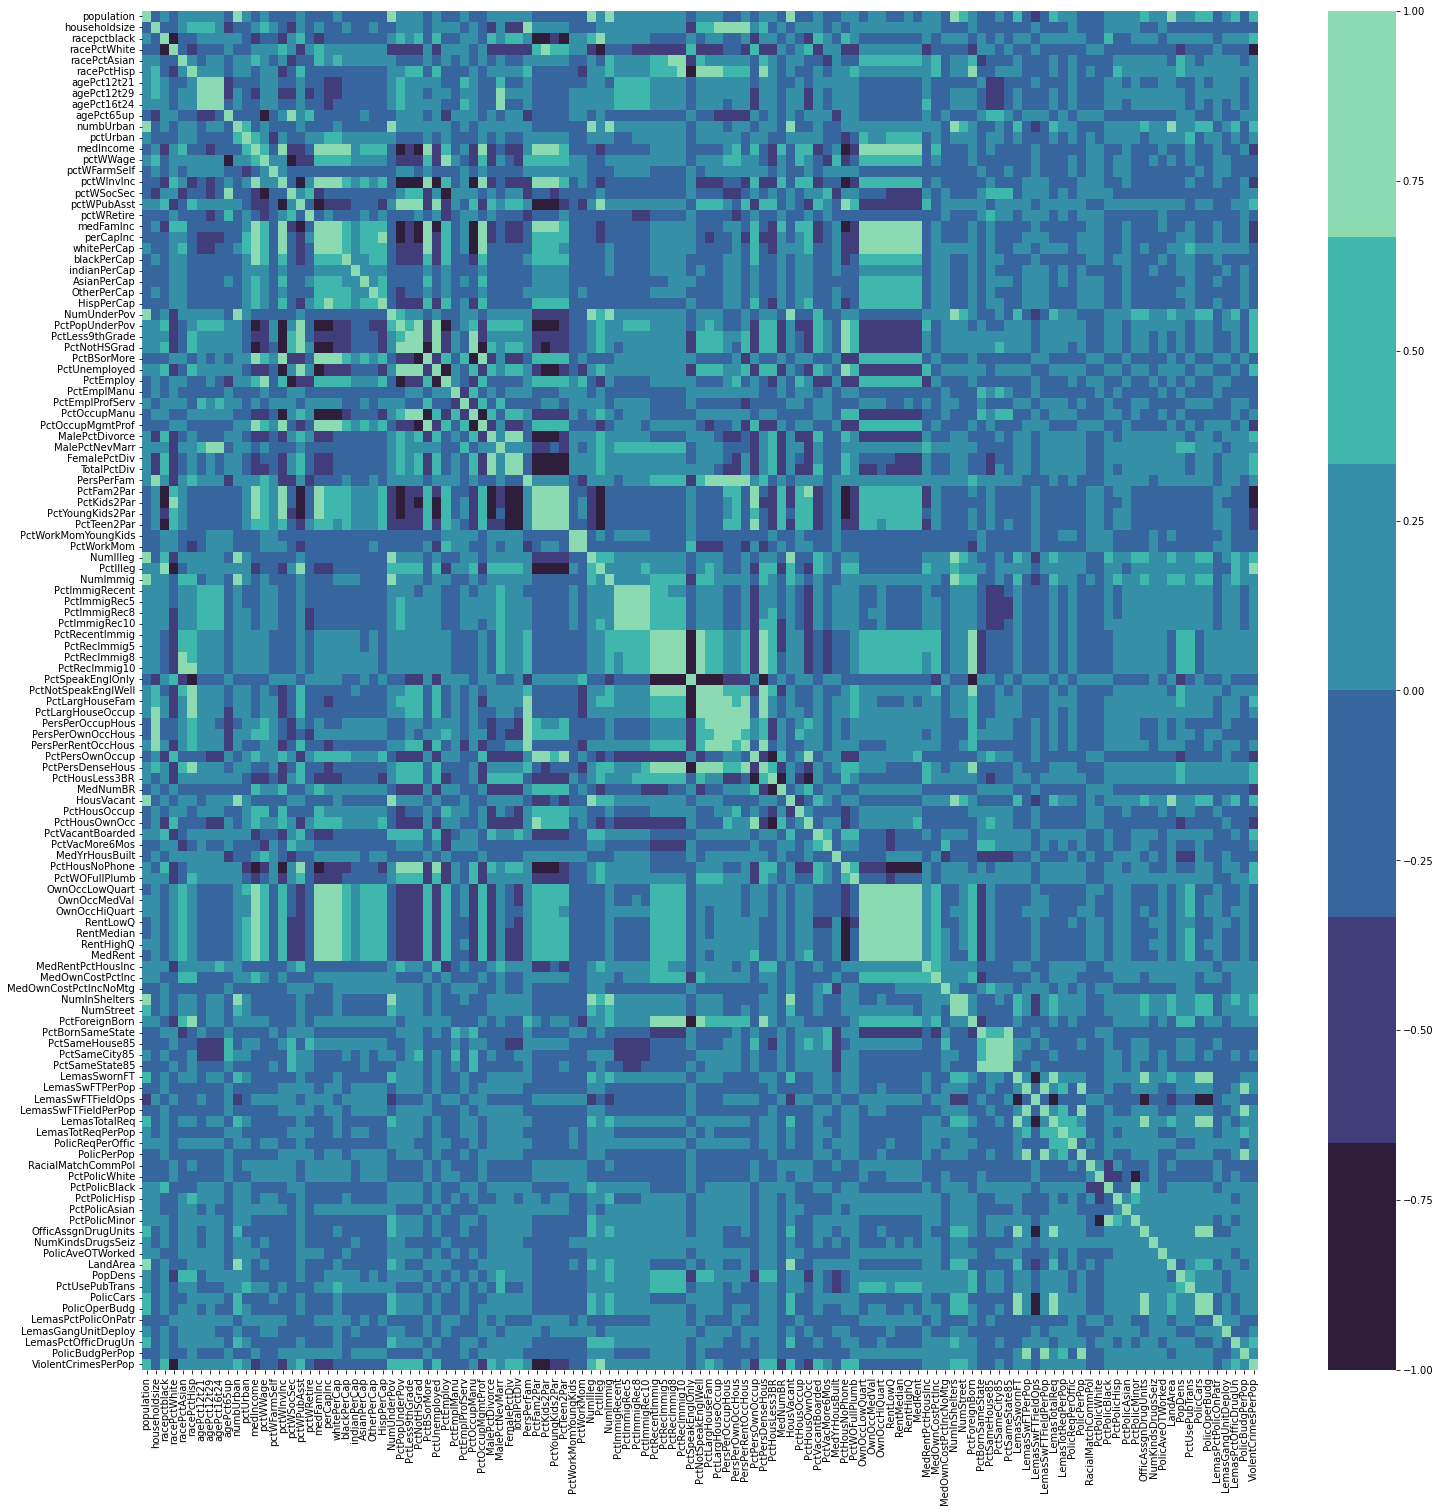

In [31]:
correlation = data.corr()
#correlation
plt.figure(figsize=(25, 25))
sns.heatmap(correlation, vmin = -1, vmax = 1, cmap = sns.color_palette("mako"),  
            xticklabels = correlation.columns, yticklabels = correlation.columns)

### (d) Calculate the Coefficient of Variation CV for each feature, where CV = s/m , in which s is sample standard deviation and m is sample mean.

In [32]:
cv = dict()
for col in data.columns:
    cv[col] = data[col].std()/data[col].mean()

In [33]:
cv

{'population': 2.203502536390972,
 'householdsize': 0.3532983018683109,
 'racepctblack': 1.4109203963756864,
 'racePctWhite': 0.3237815624993411,
 'racePctAsian': 1.3591621938222074,
 'racePctHisp': 1.614277791710685,
 'agePct12t21': 0.36583986883972397,
 'agePct12t29': 0.29069288841904145,
 'agePct16t24': 0.4951605143654288,
 'agePct65up': 0.42344170889026195,
 'numbUrban': 2.0017436381957676,
 'pctUrban': 0.6388488712113656,
 'medIncome': 0.5797533935755996,
 'pctWWage': 0.3277100586060616,
 'pctWFarmSelf': 0.7000301156104908,
 'pctWInvInc': 0.35923994722340613,
 'pctWSocSec': 0.36851263032540155,
 'pctWPubAsst': 0.699030504203365,
 'pctWRetire': 0.3496390828575848,
 'medFamInc': 0.527731885342079,
 'perCapInc': 0.545633428419145,
 'whitePerCap': 0.5075521907214038,
 'blackPerCap': 0.5894690036844645,
 'indianPerCap': 0.8096850868666168,
 'AsianPerCap': 0.6061938508790911,
 'OtherPerCap': 0.6706445725467309,
 'HispPerCap': 0.4739597186074789,
 'NumUnderPov': 2.304969714852185,
 'PctP

### (e) Pick ⌊sqrt(128)⌋ features with highest CV , and make scatter plots and box plots for them. Can you draw conclusions about significance of those features, just by the scatter plots?

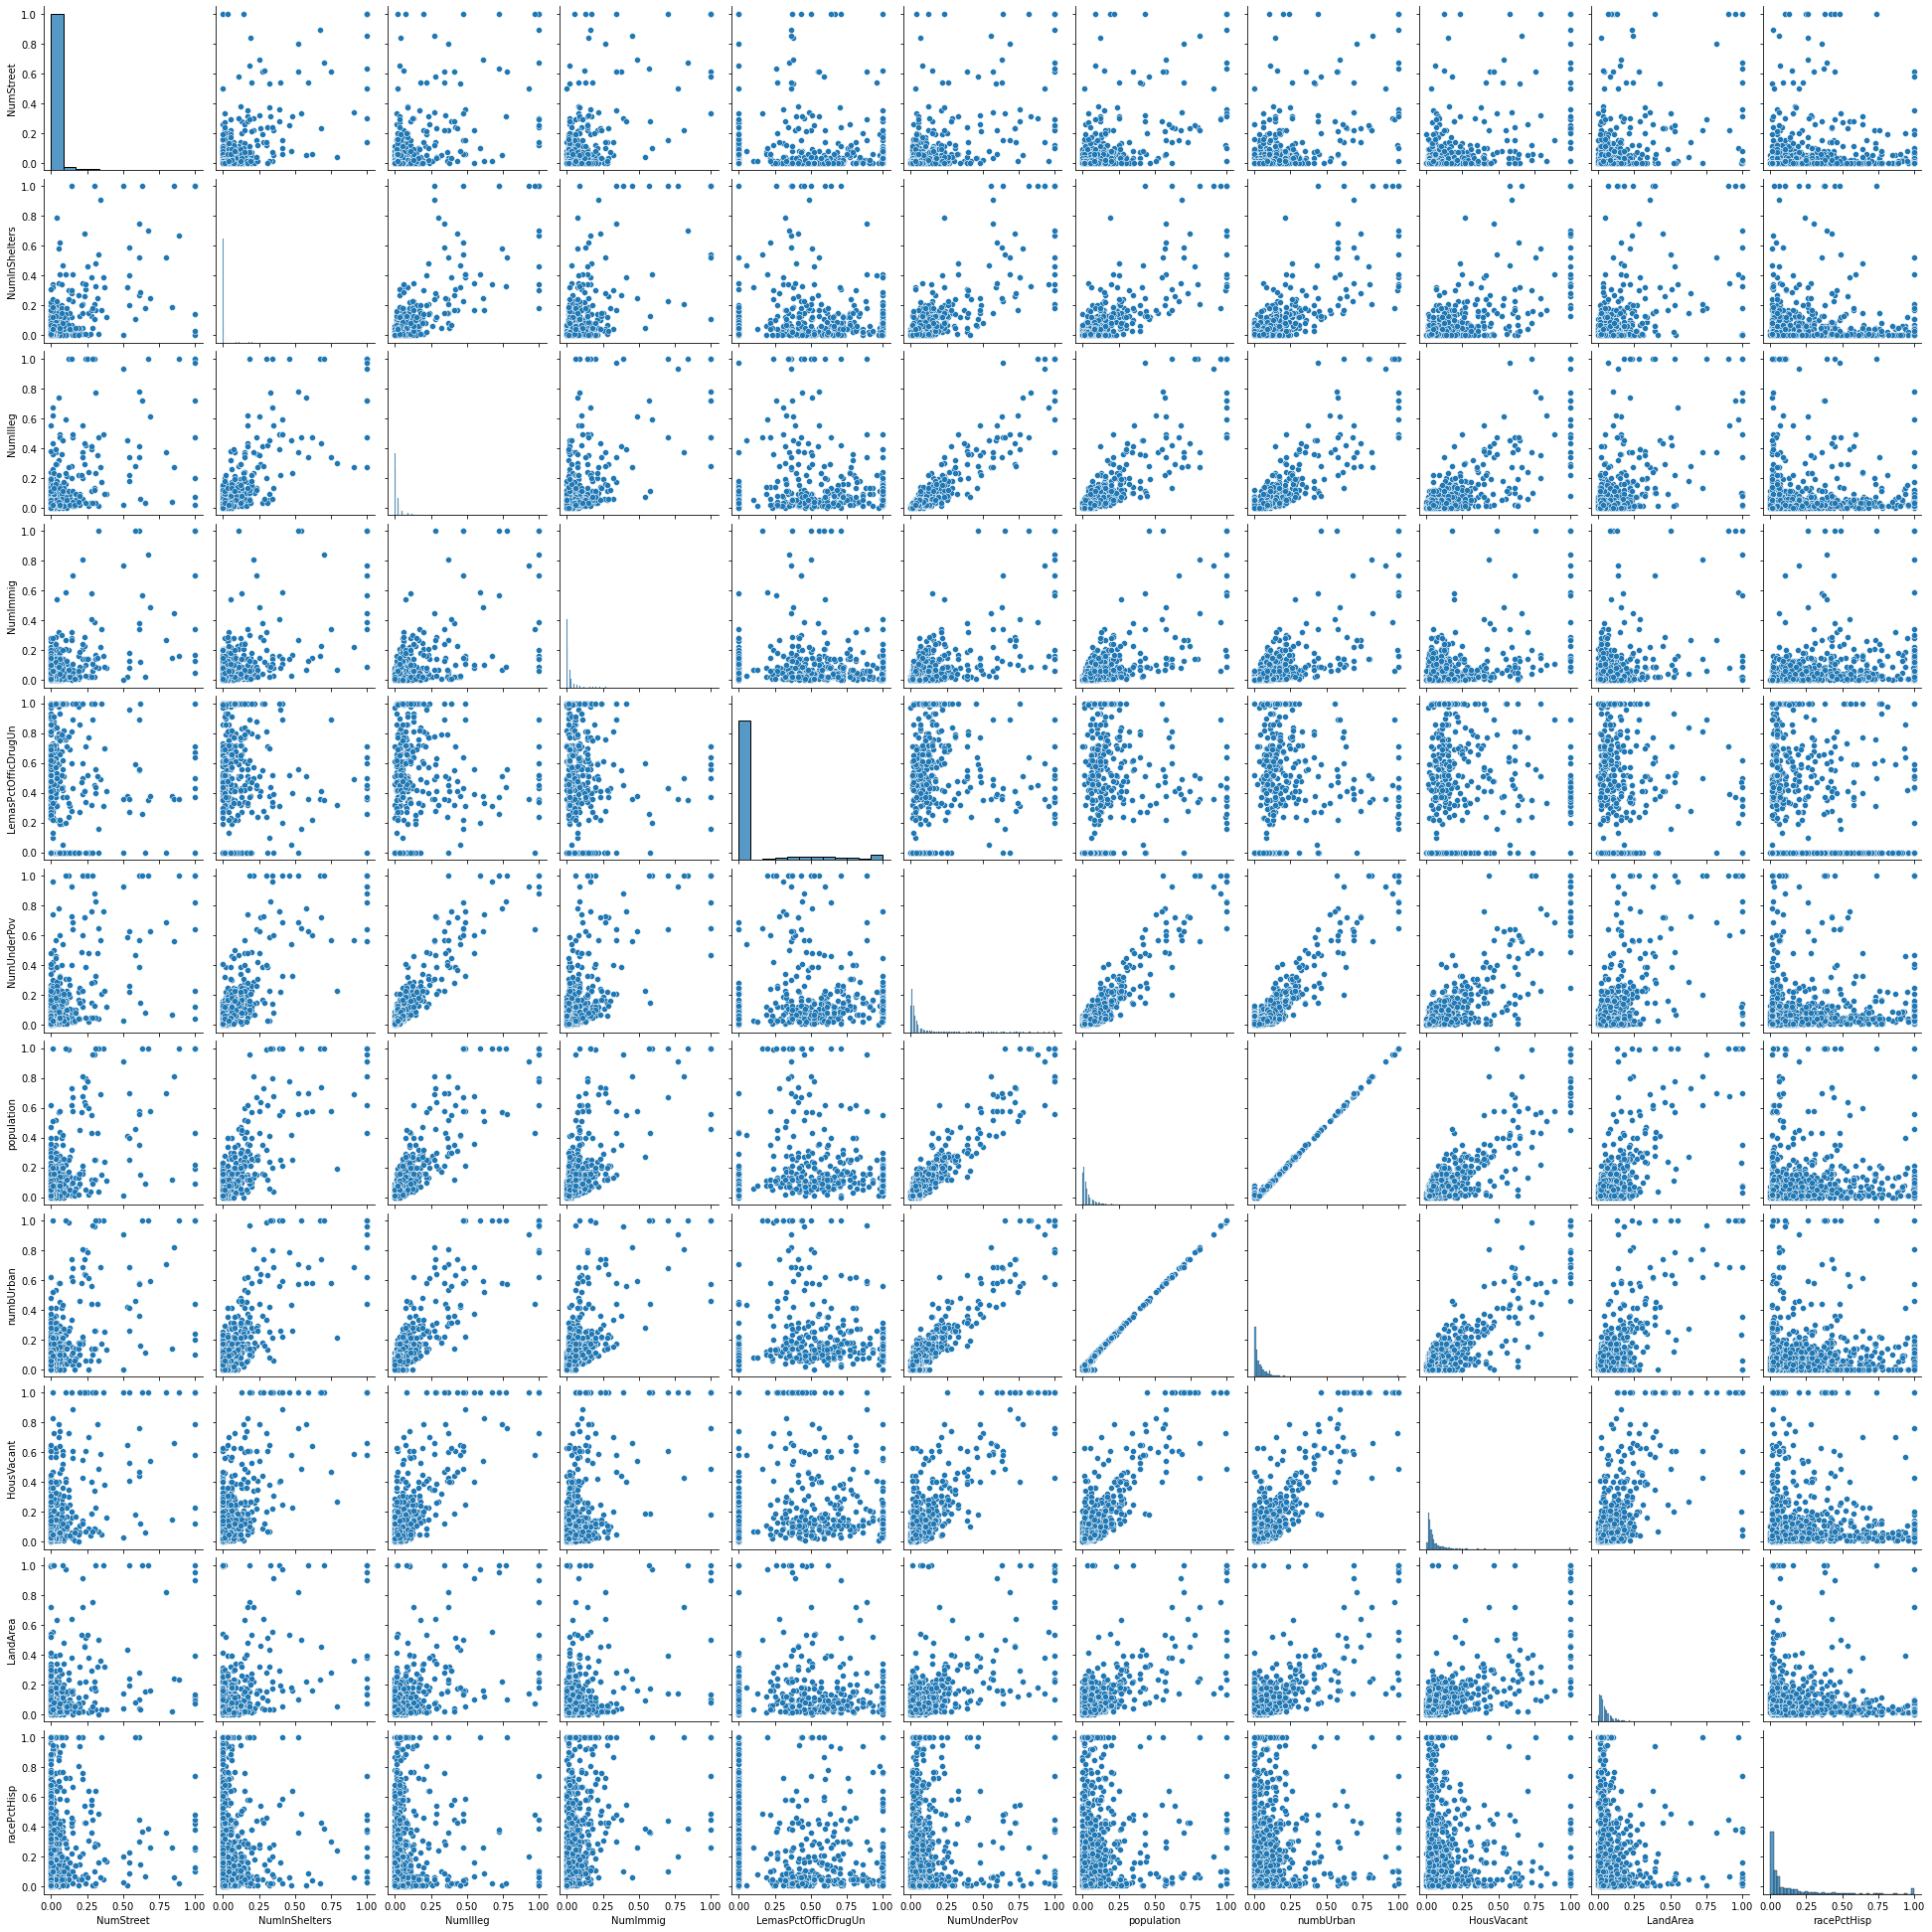

In [34]:
import math
from operator import itemgetter

# before picking the highest cv, we need to sort them first
N = math.floor(pow(128,0.5))
top_cv = dict(sorted(cv.items(), key = itemgetter(1), reverse = True)[:N])
top_cv_col = list(top_cv.keys())

top_cv_data = data.loc[:,top_cv_col]
sns.pairplot(data = top_cv_data, vars = top_cv_col, kind='scatter')

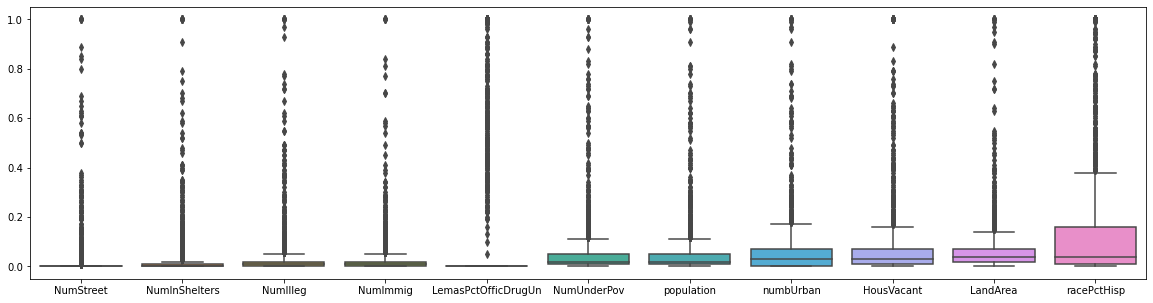

In [35]:
plt.figure(figsize=(20, 5))
plot = sns.boxplot(data = top_cv_data)

From the scatter plot, we could find that population and numbUrban have a very strong corelation.  
Besides, there are also some relationship between "Numllleg/NumUnderPov", "NumUnderPov/Population". 

### (f) Fit a linear model using least squares to the training set and report the test error.

In [36]:
training_data = data[:1495]
testing_data = data[1495:]

training_x, testing_x = training_data.drop(['ViolentCrimesPerPop'], axis=1), testing_data.drop(['ViolentCrimesPerPop'], axis=1)
training_y, testing_y = training_data['ViolentCrimesPerPop'], testing_data['ViolentCrimesPerPop']

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


linReg = LinearRegression()
linReg.fit(training_x, training_y)
linReg_predict = linReg.predict(testing_x)
print('R-Square: ', linReg.score(testing_x, testing_y))
print('Mean Square Error: ', mean_squared_error(testing_y, linReg_predict))

R-Square:  -15.606466950881451
Mean Square Error:  0.7897255274396388


### (g) Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained.

In [38]:
from sklearn.linear_model import RidgeCV #Ridge regression with built-in cross-validation

r_clf = RidgeCV(alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10, 50], cv = 5).fit(training_x, training_y)

R_pred_y = r_clf.predict(testing_x)
print('Best λ: ', r_clf.alpha_)
print('R-Square: ', r_clf.score(testing_x, testing_y))
print('Mean Square Error: ', mean_squared_error(testing_y, R_pred_y))

Best λ:  5.0
R-Square:  0.6319820360725189
Mean Square Error:  0.017501204893823938


### (h) Fit a LASSO model on the training set, with λ chosen by cross-validation. Report the test error obtained, along with a list of the variables selected by the model. Repeat with standardized features. Report the test error for both cases and compare them.

In [39]:
from sklearn.linear_model import LassoCV #The best model is selected by cross-validation

l_clf = LassoCV(alphas=[1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10, 100], cv = 5, tol=0.01).fit(training_x, training_y)

L_pred_y = l_clf.predict(testing_x)
print('===========Before standardizing features===========')
print('Best λ: ', l_clf.alpha_)
print('R-Square: ', l_clf.score(testing_x, testing_y))
print('Mean Square Error: ', mean_squared_error(testing_y, L_pred_y))

feature = list()
for i in range(len(l_clf.coef_)):
    if l_clf.coef_[i]!= 0:
        feature.append(training_x.columns[i])
print("Num of Non-Zero coeffecient feature", len(feature))
print("Feature Selected: ", feature)

===========Before standardizing features===========
Best λ:  0.0001
R-Square:  0.625779101187314
Mean Square Error:  0.017796187326774987
Num of Non-Zero coeffecient feature 78
Feature Selected:  ['racepctblack', 'racePctAsian', 'agePct12t21', 'agePct12t29', 'agePct65up', 'pctUrban', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'PctPopUnderPov', 'PctLess9thGrade', 'PctBSorMore', 'PctEmploy', 'PctEmplManu', 'PctOccupManu', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig', 'PctImmigRec10', 'PctRecImmig10', 'PctNotSpeakEnglWell', 'PctLargHouseOccup', 'PersPerOccupHous', 'PctPersOwnOccup', 'PctPersDenseHous', 'PctHousLess3BR', 'MedNumBR', 'HousVacant', 'PctHousOccup', 'PctVacantBoarded', 'PctVacMore6Mos', 'MedYrHousBuilt', 'PctHousNoPhone', 'PctWOFullPlumb', 'Ow

In [40]:
from sklearn.preprocessing import StandardScaler

standard=StandardScaler()
training_x_standard, testing_x_standard = standard.fit_transform(training_x), standard.fit_transform(testing_x)

l_clf_standard = LassoCV(alphas=[1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10, 100], cv = 5, tol=0.01).fit(training_x_standard, training_y)

L_standard_pred_y = l_clf_standard.predict(testing_x_standard)
print('===========After standardizing features===========')
print('Best λ: ', l_clf_standard.alpha_)
print('R-Square: ', l_clf_standard.score(testing_x_standard, testing_y))
print('Mean Square Error: ', mean_squared_error(testing_y, L_standard_pred_y))

standard_feature = list()
for i in range(len(l_clf_standard.coef_)):
    if l_clf_standard.coef_[i]!= 0:
        standard_feature.append(training_x.columns[i])
print("Num of Non-Zero coeffecient feature", len(standard_feature))
print("Feature Selected: ", standard_feature)

===========After standardizing features===========
Best λ:  0.001
R-Square:  0.6224038083934964
Mean Square Error:  0.017956700390134275
Num of Non-Zero coeffecient feature 70
Feature Selected:  ['racepctblack', 'agePct12t21', 'agePct12t29', 'pctUrban', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'PctPopUnderPov', 'PctLess9thGrade', 'PctEmploy', 'PctEmplManu', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'PctFam2Par', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig', 'PctImmigRec5', 'PctRecImmig10', 'PctNotSpeakEnglWell', 'PctLargHouseOccup', 'PctPersOwnOccup', 'PctPersDenseHous', 'PctHousLess3BR', 'HousVacant', 'PctHousOccup', 'PctVacantBoarded', 'PctVacMore6Mos', 'MedYrHousBuilt', 'PctHousNoPhone', 'PctWOFullPlumb', 'RentLowQ', 'MedRent', 'MedRentPctHousInc', 'MedOwnCostPctInc', 'MedOwnCostPctIncNoM

After standardizing the features, the R square and mean square error do not change a lot, but the lasso shrnkage the function more!  
More features's coefficient goes to zero.

### (i) Fit a PCR model on the training set, with M (the number of principal components) chosen by cross-validation. Report the test error obtained.

In [41]:
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import scale

bestM = 1
best_MSE = 10
M = range(1, len(data.columns))

for m in M:
    pca = PCA(n_components = m)
    # PCA is affected by scale, so you need to scale the features in your data before applying PCA.
    X_reduced = pca.fit_transform(scale(training_x))
    
    linReg = LinearRegression()
    mse = cross_val_score(linReg, X_reduced, training_y, cv = 5, 
                             scoring = 'neg_mean_squared_error')
    mean_mse = -np.mean(mse)
    
    #print(mean_mse)
    if mean_mse < best_MSE:
        best_MSE = mean_mse
        bestM = m

In [42]:
pca = PCA(n_components = bestM)

training_x_reduced = pca.fit_transform(scale(training_x))
testing_x_reduced = pca.fit_transform(scale(testing_x))

bestReg = LinearRegression().fit(training_x_reduced, training_y)
pca_predict = bestReg.predict(testing_x_reduced)

mean_mse = -np.mean(mse)
print("Best M: ", bestM)
print("Test Mean Square Error: ", mean_squared_error(testing_y, pca_predict))

Best M:  95
Test Mean Square Error:  0.04641738147136102


### (i) In this section, we would like to fit a boosting tree to the data. As in classification trees, one can use any type of regression at each node to build a multivariate regression tree. Because the number of variables is large in this problem, one can use L1-penalized regression at each node. Such a tree is called L1 penalized gradient boosting tree. You can use XGBoost to fit the model tree. Determine α (the regularization term) using cross-validation.

In [43]:
import xgboost as xgb
from xgboost import cv

xgb_train = xgb.DMatrix(training_x, label = training_y)
xgb_test = xgb.DMatrix(testing_x, label = testing_y)

alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10, 100]

bestA = 1
bestMSE = 1
for alpha in alphas:
    param = {'max_depth':6, 'learning_rate':0.1, 'objective':"reg:squarederror", 'alpha':alpha}
    xgb_cv_scores = cv(dtrain = xgb_train, params = param, nfold = 5,
                    num_boost_round = 50, early_stopping_rounds=10, metrics = "rmse", seed = 123)
    # xgb_cv_scores would return train-rmse-mean/ train-rmse-std/ test-rmse-mean/ test-rmse-std
    xgb_mse = np.mean(xgb_cv_scores['test-rmse-mean'])
    
    if xgb_mse < bestMSE:
        bestA = alpha
        bestMSE = xgb_mse
        
print('best alpha: ', bestA)
print('error rate: ',bestMSE)

best alpha:  0.1
error rate:  0.16804236399999997
